In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify as sq

In [81]:
#Load Source0: data
data = pd.read_excel("Dataset.xlsx", sheet_name="Orders", index_col = 0)

#Convert "Column Name" format into "column_name" format
data.columns = [col.lower().replace(' ', '_') for col in data.columns]

In [82]:
#Select the columns for source table & calculate total value of each order: df
df = data.groupby(["customer_id","order_id","order_date"], as_index=False)["sales"].sum()
df

,customer_id,order_id,order_date,sales
0,AA-10315,CA-2014-128055,2014-03-31,726.548
1,AA-10315,CA-2014-138100,2014-09-15,29.500
2,AA-10315,CA-2015-121391,2015-10-04,26.960
3,AA-10315,CA-2016-103982,2016-03-03,4406.072
4,AA-10315,CA-2017-147039,2017-06-29,374.480
...,...,...,...,...
5004,ZD-21925,CA-2014-143336,2014-08-27,244.760
5005,ZD-21925,CA-2016-152471,2016-07-08,839.944
5006,ZD-21925,CA-2016-167682,2016-04-03,331.080
5007,ZD-21925,CA-2017-141481,2017-06-11,61.440


In [83]:
#Load dataframe of returned orders
rtn = pd.read_excel('Dataset.xlsx', sheet_name='Return')
rtn.columns = [col.lower().replace(' ','_') for col in rtn.columns]
rtn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   returned  296 non-null    object
 1   order_id  296 non-null    object
dtypes: object(2)
memory usage: 4.8+ KB


In [84]:
#Exclude returned orders
df_rtn = df.merge(rtn, how='left', on='order_id')
df_rtn.drop(df_rtn[(df_rtn['returned']=='Yes')].index, inplace = True)
df_rtn.drop("returned", axis = 1, inplace=True)
df_rtn

,customer_id,order_id,order_date,sales
0,AA-10315,CA-2014-128055,2014-03-31,726.548
1,AA-10315,CA-2014-138100,2014-09-15,29.500
2,AA-10315,CA-2015-121391,2015-10-04,26.960
3,AA-10315,CA-2016-103982,2016-03-03,4406.072
4,AA-10315,CA-2017-147039,2017-06-29,374.480
...,...,...,...,...
5003,ZC-21910,US-2017-102288,2017-06-19,148.884
5005,ZD-21925,CA-2016-152471,2016-07-08,839.944
5006,ZD-21925,CA-2016-167682,2016-04-03,331.080
5007,ZD-21925,CA-2017-141481,2017-06-11,61.440


In [85]:
#Calculate rfm at the moment
from datetime import datetime
today = datetime(2017,12,31)
rfm = df_rtn.groupby('customer_id').agg({'order_date':'max', 'order_id':'size', 'sales': 'sum'}).reset_index()
rfm.columns = ['customer_id', 'max_date', 'frequency', 'monetary']
rfm['recency'] = (today-rfm['max_date']).dt.days
rfm.drop('max_date', axis=1, inplace=True)
rfm = rfm[['customer_id', 'recency', 'frequency', 'monetary']]
rfm

,customer_id,recency,frequency,monetary
0,AA-10315,185,5,5563.560
1,AA-10375,20,9,1056.390
2,AA-10480,260,4,1790.512
3,AA-10645,483,5,5073.975
4,AB-10015,416,3,886.156
...,...,...,...,...
786,XP-21865,83,9,2110.726
787,YC-21895,5,4,5438.650
788,YS-21880,10,8,6720.444
789,ZC-21910,55,12,7892.998


In [86]:
#Score RFM by using Quintiles
r_labels, f_labels, m_labels = range(5,0,-1), range(1,6), range(1,6)
rfm['r_score'] = pd.qcut(rfm['recency'], q=5, labels=r_labels)
rfm['f_score'] = pd.qcut(rfm['frequency'], q=5, labels=f_labels)
rfm['m_score'] = pd.qcut(rfm['monetary'], q=5, labels=m_labels)

rfm['rfm_score'] = rfm['r_score'].astype(str) + rfm['f_score'].astype(str) + rfm['m_score'].astype(str) 
rfm['rfm_score'] = rfm['rfm_score'].astype(int)
rfm

,customer_id,recency,frequency,monetary,r_score,f_score,m_score,rfm_score
0,AA-10315,185,5,5563.560,2,2,5,225
1,AA-10375,20,9,1056.390,5,5,2,552
2,AA-10480,260,4,1790.512,2,1,3,213
3,AA-10645,483,5,5073.975,1,2,5,125
4,AB-10015,416,3,886.156,1,1,2,112
...,...,...,...,...,...,...,...,...
786,XP-21865,83,9,2110.726,3,5,3,353
787,YC-21895,5,4,5438.650,5,1,5,515
788,YS-21880,10,8,6720.444,5,4,5,545
789,ZC-21910,55,12,7892.998,4,5,5,455


In [87]:
#Load Segment defination: data
data = pd.read_excel('Dataset.xlsx', sheet_name='Sheet2')
data.columns = [col.lower().replace(' ','_') for col in data.columns]
data

,segment,rfm_score
0,Champions,"555, 554, 544, 545, 454, 455, 445"
1,Loyal,"543, 444, 435, 355, 354, 345, 344, 335"
2,Potential Loyalist,"553, 551, 552, 541, 542, 533, 532, 531, 452, 4..."
3,New Customers,"512, 511, 422, 421, 412, 411, 311"
4,Promising,"525, 524, 523, 522, 521, 515, 514, 513, 425,42..."
5,Need Attention,"535, 534, 443, 434, 343, 334, 325, 324"
6,About To Sleep,"331, 321, 312, 221, 213, 231, 241, 251"
7,At Risk,"255, 254, 245, 244, 253, 252, 243, 242, 235, 2..."
8,Cannot Lose Them,"155, 154, 144, 214, 215, 115, 114, 113"
9,Hibernating customers,"332, 322, 233, 232, 223, 222, 132, 123, 122, 2..."


In [88]:
#Convert comma-seperated string to a list of rfm scores

data['rfm_score'] = data['rfm_score'].str.split(',')
data = data.explode('rfm_score').reset_index(drop=True)
data['rfm_score'] = data['rfm_score'].astype(int)
data.sort_values(by='rfm_score')
data.head(10)

,segment,rfm_score
0,Champions,555
1,Champions,554
2,Champions,544
3,Champions,545
4,Champions,454
5,Champions,455
6,Champions,445
7,Loyal,543
8,Loyal,444
9,Loyal,435


In [89]:
#Segment customer base on R, F, M
seg = rfm.merge(data, how='left', on='rfm_score')
seg
rfm['segment'] = seg['segment']

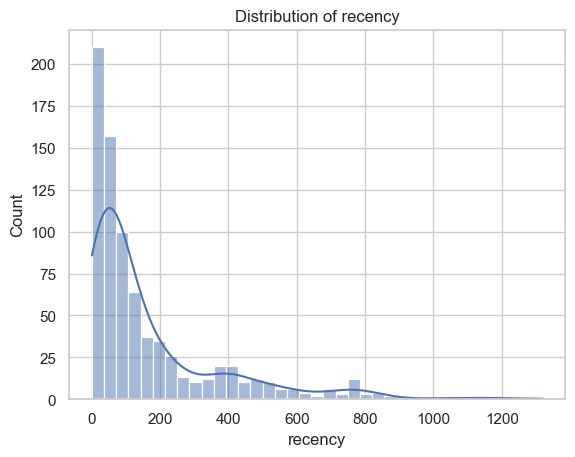

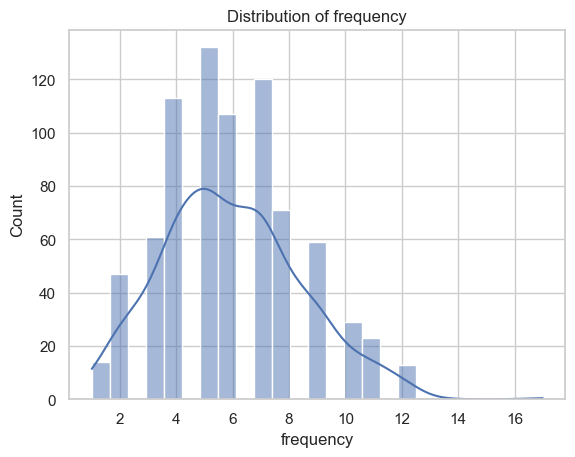

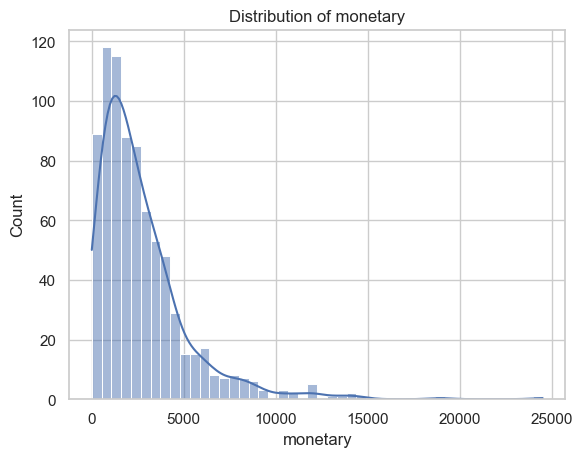

In [90]:
colnames = [rfm['recency'], rfm['frequency'], rfm['monetary']]
for col in colnames:
    sns.histplot(col, kde=True)
    plt.title('Distribution of %s' %col.name, loc="center")
    plt.show()

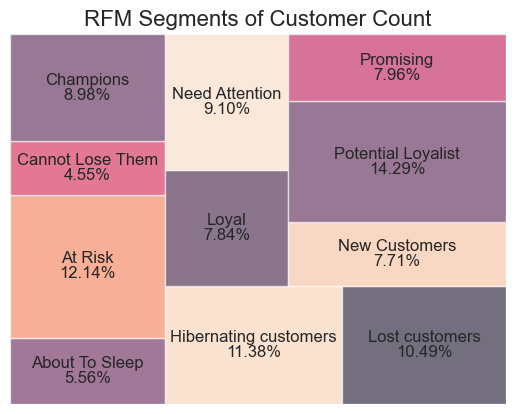

In [91]:
#Plot treemap - RFM Segments of Customer Count
data = rfm.groupby('segment')['customer_id'].count()

label = data.index
sizes = data.values
value = [f'{ (x/sizes.sum()*100) :.2f}%' for x in sizes]

sq.plot(sizes=sizes, label=label, value=value, alpha=0.6, bar_kwargs = dict(linewidth=1, edgecolor="white"))
plt.title("RFM Segments of Customer Count", fontsize=16)
plt.axis("off")
plt.show()

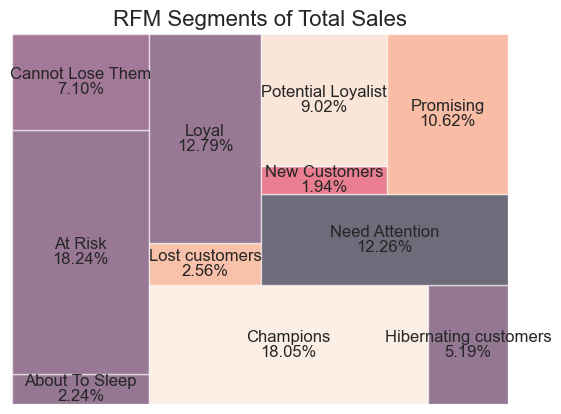

In [92]:
#Plot treemap - RFM Segments of Total Sales
data = rfm.groupby("segment")["monetary"].sum()
label = data.index
sizes = data.values
value = [f'{ (x/sizes.sum()*100) :.2f}%' for x in sizes]

sq.plot(sizes=sizes, label=label, value=value, alpha=0.6, bar_kwargs = dict(linewidth=1, edgecolor="white"))
plt.title("RFM Segments of Total Sales", fontsize=16)
plt.axis("off")
plt.show()

Interactive Visualizations using ploty

In [93]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "browser"  # Opens plot in a browser window


# Interactive scatter plot of RFM dimensions
fig = px.scatter_3d(rfm, x='recency', y='frequency', z='monetary', 
                     color='segment', size='monetary',
                     hover_name='customer_id', opacity=0.7,
                     title='3D Interactive RFM Visualization')
fig.update_layout(scene=dict(xaxis_title='Recency', yaxis_title='Frequency', zaxis_title='Monetary'))
fig.show()

# Interactive segment distribution
fig = px.bar(rfm.groupby('segment').size().reset_index(name='count'), 
             x='segment', y='count', color='segment',
             title='Customer Distribution Across RFM Segments')
fig.show()

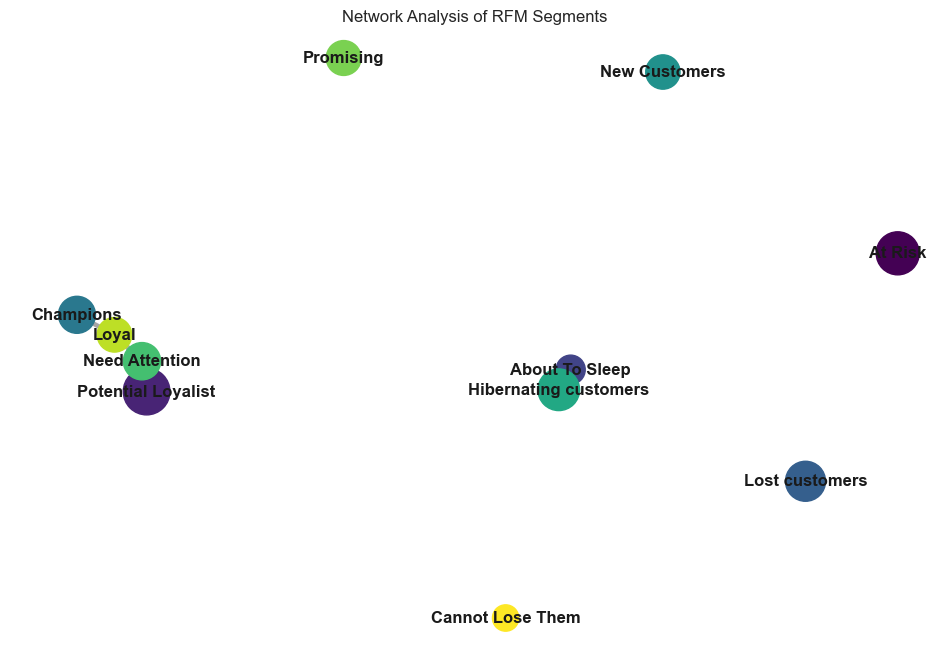

In [94]:
import networkx as nx

# Ensure numerical data for scoring columns
rfm[['r_score', 'f_score', 'm_score']] = rfm[['r_score', 'f_score', 'm_score']].apply(pd.to_numeric, errors='coerce')

# Create a network graph
G = nx.Graph()

# Add nodes for each segment
segments = rfm['segment'].unique()
for segment in segments:
    G.add_node(segment, size=len(rfm[rfm['segment'] == segment]))

# Add edges between segments based on similarity
for i, seg1 in enumerate(segments):
    for seg2 in segments[i+1:]:
        seg1_avg = rfm.loc[rfm['segment'] == seg1, ['r_score', 'f_score', 'm_score']].mean()
        seg2_avg = rfm.loc[rfm['segment'] == seg2, ['r_score', 'f_score', 'm_score']].mean()
        
        similarity = 1 / (1 + np.sum(np.abs(seg1_avg - seg2_avg)))
        if similarity > 0.3:  # Only add edge if segments are somewhat similar
            G.add_edge(seg1, seg2, weight=similarity * 10)

# Visualize the network
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
node_sizes = [G.nodes[node]['size'] * 10 for node in G.nodes]
edge_weights = [G.edges[edge]['weight'] for edge in G.edges]

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=range(len(G.nodes)), cmap=plt.cm.viridis)
nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.7, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

plt.title('Network Analysis of RFM Segments')
plt.axis('off')
plt.show()


RFM analysis dashboard

In [95]:
# Create an interactive dashboard for RFM analysis using Plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

# Create a full interactive dashboard
def create_rfm_dashboard(rfm_data):
    # Create subplots
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=("Segment Distribution", "Average RFM Values by Segment", 
                        "Recency vs. Frequency", "Monetary by Segment"),
        specs=[[{"type": "pie"}, {"type": "bar"}],
               [{"type": "scatter"}, {"type": "box"}]],
        vertical_spacing=0.1,
        horizontal_spacing=0.05
    )
    
    # 1. Segment Distribution Pie Chart
    segment_counts = rfm_data['segment'].value_counts()
    fig.add_trace(
        go.Pie(
            labels=segment_counts.index,
            values=segment_counts.values,
            textinfo='percent+label',
            hole=0.3,
            marker=dict(colors=px.colors.qualitative.Plotly)
        ),
        row=1, col=1
    )
    
    # 2. Average RFM Values by Segment Bar Chart
    segment_avg = rfm_data.groupby('segment')[['recency', 'frequency', 'monetary']].mean().reset_index()
    
    # Normalize the values for better visualization
    segment_avg['recency_norm'] = segment_avg['recency'] / segment_avg['recency'].max()
    segment_avg['frequency_norm'] = segment_avg['frequency'] / segment_avg['frequency'].max()
    segment_avg['monetary_norm'] = segment_avg['monetary'] / segment_avg['monetary'].max()
    
    fig.add_trace(
        go.Bar(x=segment_avg['segment'], y=segment_avg['recency_norm'], name='Recency', 
               marker_color='red', text=segment_avg['recency'].round(1), textposition='auto'),
        row=1, col=2
    )
    
    fig.add_trace(
        go.Bar(x=segment_avg['segment'], y=segment_avg['frequency_norm'], name='Frequency', 
               marker_color='green', text=segment_avg['frequency'].round(1), textposition='auto'),
        row=1, col=2
    )
    
    fig.add_trace(
        go.Bar(x=segment_avg['segment'], y=segment_avg['monetary_norm'], name='Monetary', 
               marker_color='blue', text=segment_avg['monetary'].round(1), textposition='auto'),
        row=1, col=2
    )
    
    # 3. Recency vs. Frequency Scatter Plot
    for segment in rfm_data['segment'].unique():
        subset = rfm_data[rfm_data['segment'] == segment]
        fig.add_trace(
            go.Scatter(
                x=subset['recency'], 
                y=subset['frequency'],
                mode='markers',
                marker=dict(
                    size=subset['monetary'] / subset['monetary'].max() * 20,  # Size based on monetary value
                    opacity=0.6
                ),
                name=segment,
                text=subset['customer_id'],
                hovertemplate=
                '<b>%{text}</b><br>' +
                'Recency: %{x:.1f} days<br>' +
                'Frequency: %{y:.1f}<br>' +
                'Monetary: $%{marker.size:.1f}<br>' +
                'Segment: ' + segment
            ),
            row=2, col=1
        )
    
    # 4. Monetary by Segment Box Plot
    fig.add_trace(
        go.Box(
            x=rfm_data['segment'],
            y=rfm_data['monetary'],
            marker_color='lightseagreen',
            boxmean=True
        ),
        row=2, col=2
    )
    
    # Update layout
    fig.update_layout(
        title_text="RFM Analysis Interactive Dashboard",
        height=800,
        width=1200,
        showlegend=False,
        title_font=dict(size=24),
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )
    
    fig.update_xaxes(title_text="Segment", row=1, col=2)
    fig.update_xaxes(title_text="Recency (days)", row=2, col=1)
    fig.update_xaxes(title_text="Segment", row=2, col=2)
    
    fig.update_yaxes(title_text="Normalized Value", row=1, col=2)
    fig.update_yaxes(title_text="Frequency", row=2, col=1)
    fig.update_yaxes(title_text="Monetary Value ($)", row=2, col=2)
    
    return fig

# Create dashboard with our RFM data
dashboard = create_rfm_dashboard(rfm)
dashboard.show()

# Save the dashboard as an HTML file that can be viewed in a browser
dashboard.write_html("rfm_interactive_dashboard.html")

# Additional dynamic visualization: Customer Journey Timeline
def create_customer_journey_timeline(transaction_data, customer_id):
    """Create an interactive timeline of a customer's journey and RFM progression"""
    # Filter data for the specific customer
    customer_orders = transaction_data[transaction_data['customer_id'] == customer_id].sort_values('order_date')
    
    if len(customer_orders) == 0:
        return None
    
    # Calculate cumulative metrics
    customer_orders['cumulative_sales'] = customer_orders['sales'].cumsum()
    customer_orders['order_number'] = range(1, len(customer_orders) + 1)
    
    # Create figure
    fig = make_subplots(
        rows=2, cols=1,
        subplot_titles=("Order Timeline", "Cumulative Monetary Value"),
        specs=[[{"type": "scatter"}], [{"type": "scatter"}]],
        vertical_spacing=0.1
    )
    
    # Order timeline
    fig.add_trace(
        go.Scatter(
            x=customer_orders['order_date'],
            y=customer_orders['sales'],
            mode='markers+lines',
            name='Order Value',
            marker=dict(size=10),
            text=customer_orders['order_id'],
            hovertemplate='<b>Order ID: %{text}</b><br>Date: %{x}<br>Value: $%{y:.2f}'
        ),
        row=1, col=1
    )
    
    # Cumulative value
    fig.add_trace(
        go.Scatter(
            x=customer_orders['order_date'],
            y=customer_orders['cumulative_sales'],
            mode='lines',
            name='Cumulative Value',
            line=dict(width=3, color='green'),
            hovertemplate='Date: %{x}<br>Cumulative Value: $%{y:.2f}'
        ),
        row=2, col=1
    )
    
    # Update layout
    fig.update_layout(
        title_text=f"Customer Journey Timeline for Customer ID: {customer_id}",
        height=600,
        width=1000,
        showlegend=True
    )
    
    fig.update_xaxes(title_text="Order Date", row=1, col=1)
    fig.update_xaxes(title_text="Order Date", row=2, col=1)
    
    fig.update_yaxes(title_text="Order Value ($)", row=1, col=1)
    fig.update_yaxes(title_text="Cumulative Value ($)", row=2, col=1)
    
    return fig

# Example usage - create journey for a sample customer
sample_customer = df_rtn['customer_id'].value_counts().index[0]  # Most frequent customer
customer_journey = create_customer_journey_timeline(df_rtn, sample_customer)
customer_journey.show()

# Function to create a heatmap of segment trends over customer lifecycle
def create_segment_transition_heatmap(rfm_data, transaction_data):
    """
    Creates a heatmap showing how segments transition based on customer age
    """
    # Calculate customer age in days (time since first purchase)
    customer_first_purchase = transaction_data.groupby('customer_id')['order_date'].min().reset_index()
    customer_first_purchase.columns = ['customer_id', 'first_purchase']
    
    customer_age = pd.merge(
        rfm_data[['customer_id', 'segment']], 
        customer_first_purchase,
        on='customer_id'
    )
    
    customer_age['days_since_first_purchase'] = (datetime(2017, 12, 31) - customer_age['first_purchase']).dt.days
    
    # Create age bins
    age_bins = [0, 90, 180, 365, 730, np.inf]
    age_labels = ['0-3 months', '3-6 months', '6-12 months', '12-24 months', '24+ months']
    customer_age['age_group'] = pd.cut(customer_age['days_since_first_purchase'], bins=age_bins, labels=age_labels)
    
    # Create segment distribution by age group
    segment_by_age = pd.crosstab(
        customer_age['age_group'],
        customer_age['segment'],
        normalize='index'
    ) * 100
    
    # Create heatmap
    fig = px.imshow(
        segment_by_age,
        text_auto='.1f',
        labels=dict(x="Segment", y="Customer Age", color="Percentage"),
        x=segment_by_age.columns,
        y=segment_by_age.index,
        color_continuous_scale='Viridis',
        title='Customer Segment Distribution by Customer Age'
    )
    
    fig.update_layout(
        height=600,
        width=900,
        xaxis_title="Segment",
        yaxis_title="Customer Age Group",
        coloraxis_colorbar=dict(title="Percentage of Customers")
    )
    
    return fig

# Create segment transition heatmap
segment_age_heatmap = create_segment_transition_heatmap(rfm, df_rtn)
segment_age_heatmap.show()

Churn prediction Model 

Churn Prediction Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       130
           1       1.00      1.00      1.00       108

    accuracy                           1.00       238
   macro avg       1.00      1.00      1.00       238
weighted avg       1.00      1.00      1.00       238



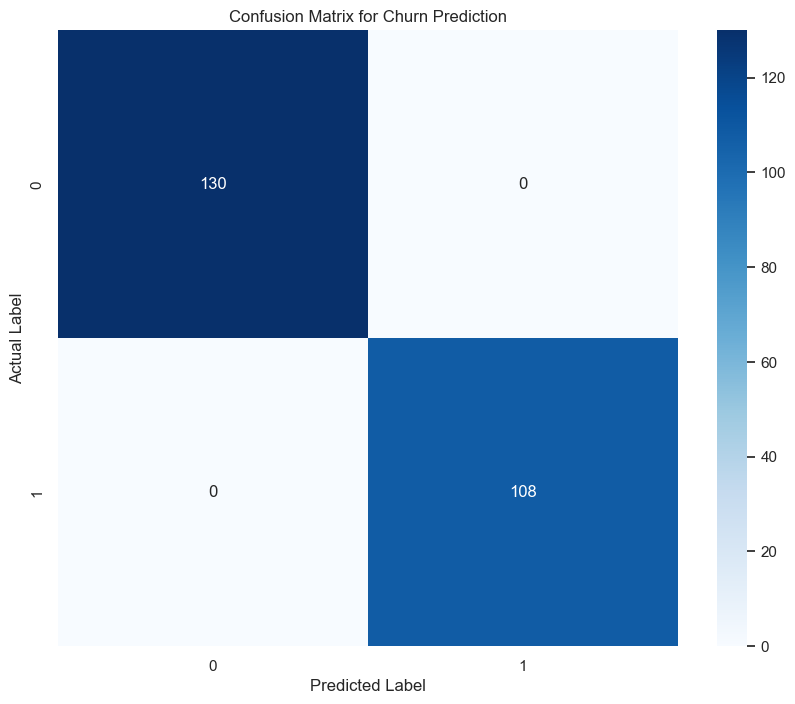

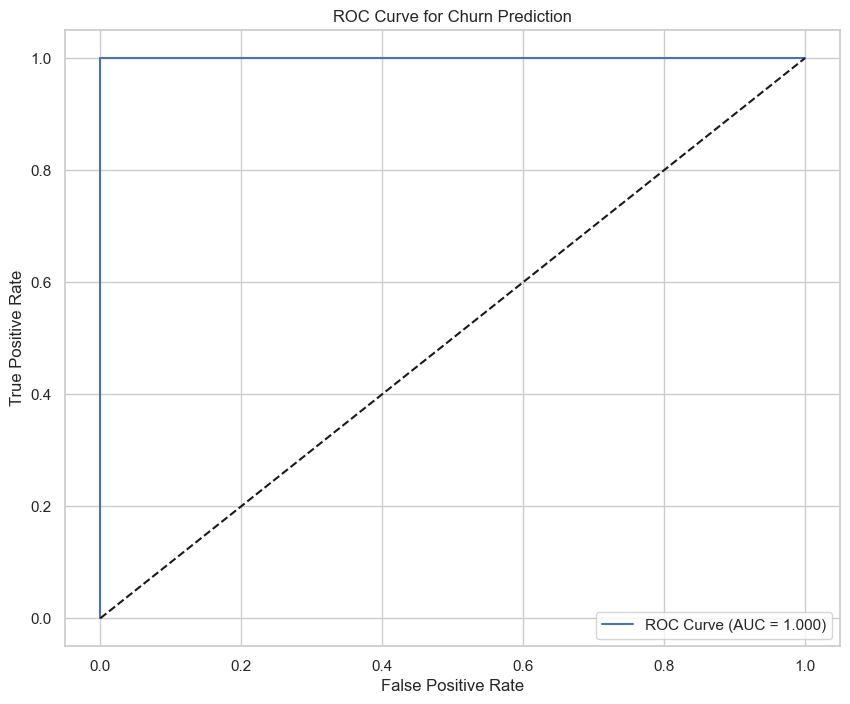

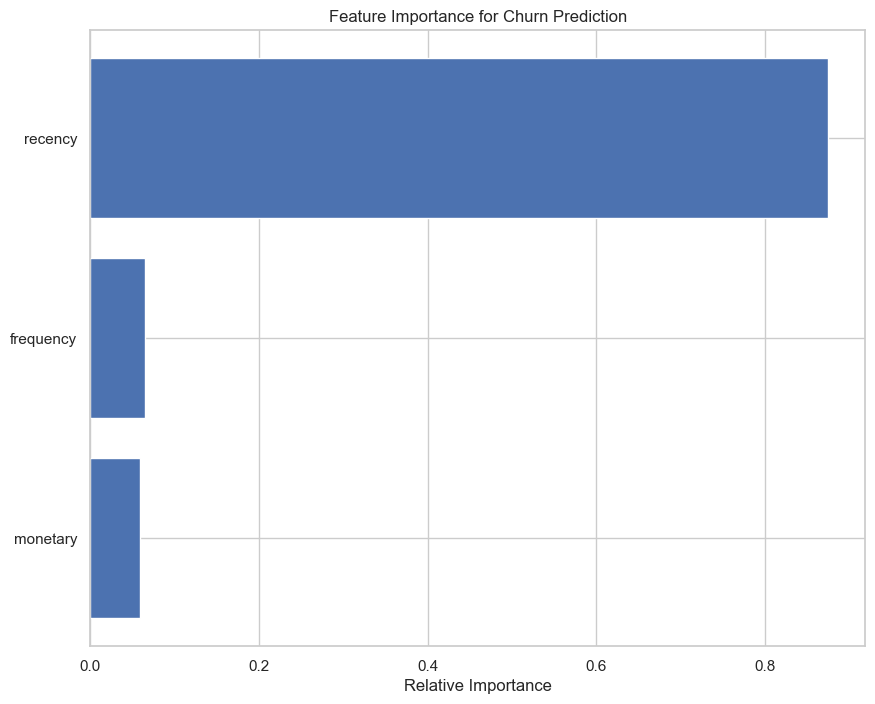

In [96]:
# Using RFM variables as features to predict churn

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

# First, let's define churn based on recency
# For this example, we'll consider customers who haven't ordered in 90+ days as churned
rfm['churned'] = (rfm['recency'] > 90).astype(int)

# Prepare features and target
X = rfm[['recency', 'frequency', 'monetary']]
y = rfm['churned']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)
y_pred_prob = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
print("Churn Prediction Model Performance:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Churn Prediction')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot ROC curve
plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_prob):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Churn Prediction')
plt.legend()
plt.show()

# Feature importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 8))
plt.title('Feature Importance for Churn Prediction')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


CUSTOMER LIFETIME VALUE (CLV) PREDICTION


CLV Prediction Model Performance:
MAE: 0.54
RMSE: 2.13
R² Score: 0.91


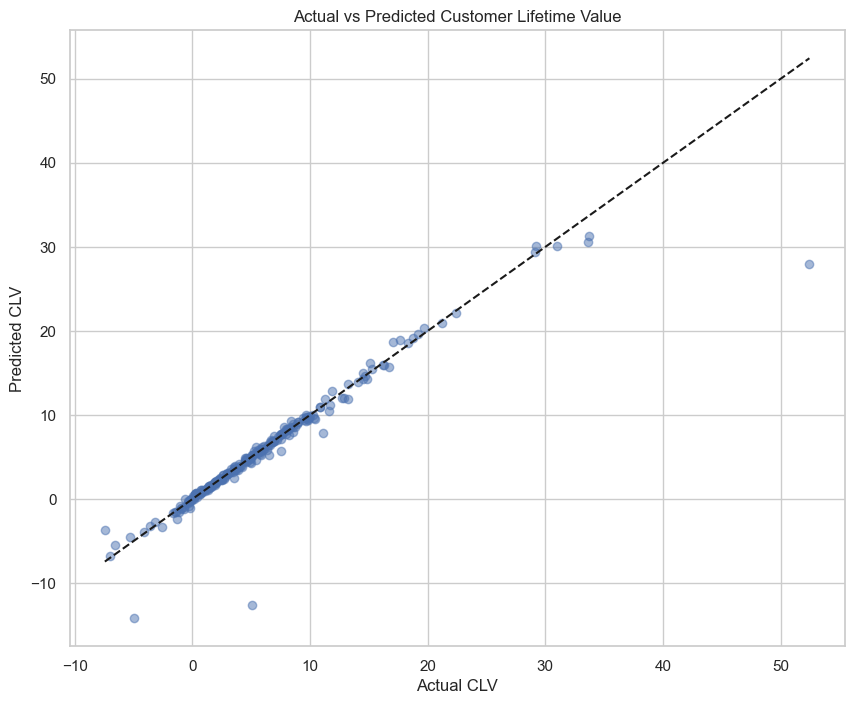

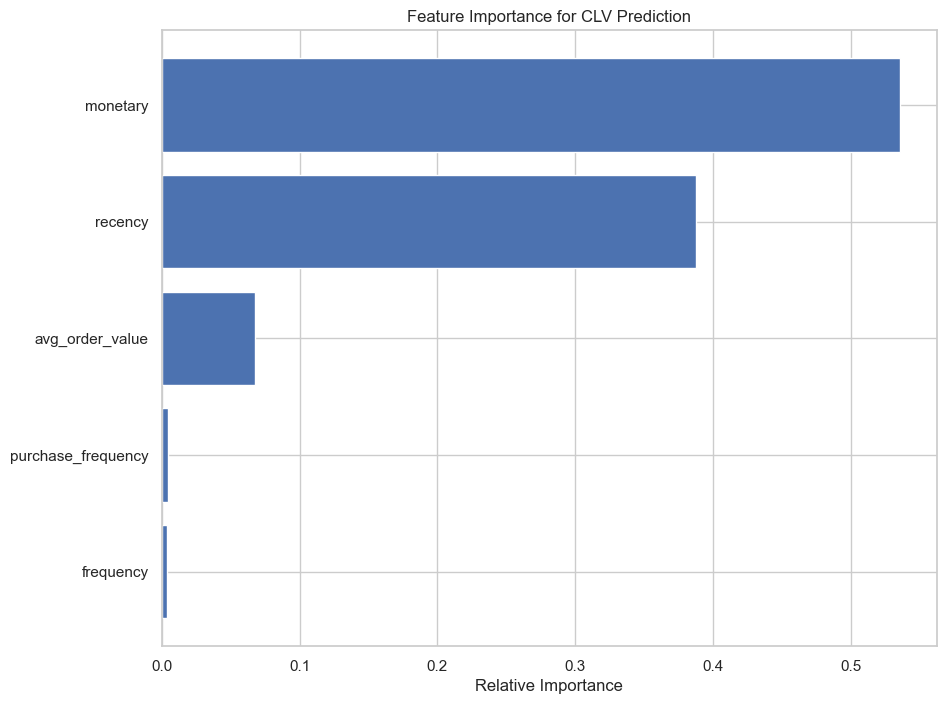

In [97]:
# Developing a model to forecast future value of customers

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# For CLV, we'll predict future monetary value based on RFM metrics
# First, let's create additional features to improve prediction
rfm['avg_order_value'] = rfm['monetary'] / rfm['frequency']
rfm['purchase_frequency'] = rfm['frequency'] / 365  # Assuming 1 year of data
rfm['time_since_first_purchase'] = 365  # Simplified assumption for this example

# Prepare features and target for CLV prediction
X_clv = rfm[['recency', 'frequency', 'monetary', 'avg_order_value', 'purchase_frequency']]

# Estimate future 1-year CLV (simplified for example)
# In a real application, you might use more sophisticated methods like the Beta Geometric/NBD model
rfm['future_clv'] = rfm['avg_order_value'] * rfm['purchase_frequency'] * (1 - (rfm['recency'] / 365))
y_clv = rfm['future_clv']

# Split the data
X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.3, random_state=42)

# Scale features
X_train_clv_scaled = scaler.fit_transform(X_train_clv)
X_test_clv_scaled = scaler.transform(X_test_clv)

# Train a GBM regression model for CLV prediction
gbm_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbm_model.fit(X_train_clv_scaled, y_train_clv)

# Make predictions
y_pred_clv = gbm_model.predict(X_test_clv_scaled)

# Evaluate the model
print("\nCLV Prediction Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_clv, y_pred_clv):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_clv, y_pred_clv)):.2f}")
print(f"R² Score: {r2_score(y_test_clv, y_pred_clv):.2f}")

# Plot actual vs predicted CLV
plt.figure(figsize=(10, 8))
plt.scatter(y_test_clv, y_pred_clv, alpha=0.5)
plt.plot([y_test_clv.min(), y_test_clv.max()], [y_test_clv.min(), y_test_clv.max()], 'k--')
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.title('Actual vs Predicted Customer Lifetime Value')
plt.show()

# Feature importance for CLV prediction
importances_clv = gbm_model.feature_importances_
indices_clv = np.argsort(importances_clv)

plt.figure(figsize=(10, 8))
plt.title('Feature Importance for CLV Prediction')
plt.barh(range(len(indices_clv)), importances_clv[indices_clv], align='center')
plt.yticks(range(len(indices_clv)), [X_clv.columns[i] for i in indices_clv])
plt.xlabel('Relative Importance')
plt.show()

NEXT PURCHASE PREDICTION

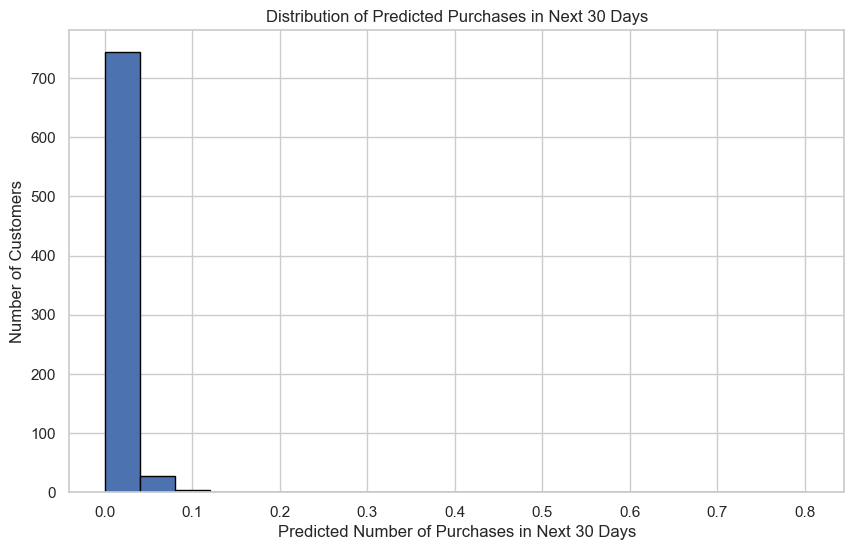

In [98]:
from lifetimes import BetaGeoFitter, GammaGammaFitter

# Set a reference date (today)
today = df_rtn['order_date'].max()

# Compute customer summary statistics
summary = df_rtn.groupby('customer_id').agg({
    'order_date': [lambda x: (today - x.max()).days,  # recency: days since last purchase
                   lambda x: (today - x.min()).days],  # T: days since first purchase
    'order_id': 'count',  # frequency: total number of purchases
    'sales': 'sum'  # monetary: total sales
})

summary.columns = ['recency', 'T', 'frequency', 'monetary']

# Fix incorrect recency values
summary['recency'] = summary[['recency', 'T']].min(axis=1)

# Remove customers with no repeat purchases (BG/NBD requires frequency > 0)
summary = summary[summary['frequency'] > 1]

# Fit the BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

# Predict purchases for next 30 days
summary['predicted_purchases_30days'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    30, 
    summary['frequency'],
    summary['recency'], 
    summary['T']
)

# Plot predictions
plt.figure(figsize=(10, 6))
plt.hist(summary['predicted_purchases_30days'], bins=20, edgecolor='black')
plt.xlabel('Predicted Number of Purchases in Next 30 Days')
plt.ylabel('Number of Customers')
plt.title('Distribution of Predicted Purchases in Next 30 Days')
plt.show()


Finding The Top Customers For Each Category

In [99]:
import pandas as pd

# Load dataset
df = pd.read_excel("Dataset.xlsx", sheet_name="Orders")
df.columns = [col.lower().replace(" ", "_") for col in df.columns]
df["order_date"] = pd.to_datetime(df["order_date"])

# Load returns data and filter out returned orders
returns = pd.read_excel("Dataset.xlsx", sheet_name="Return")
returns.columns = [col.lower().replace(" ", "_") for col in returns.columns]
df = df.merge(returns, how="left", on="order_id")
df = df[df["returned"] != "Yes"].drop(columns=["returned"], errors="ignore")

# Define reference date
reference_date = df["order_date"].max()

# Compute RFM Metrics
rfm = df.groupby("customer_id").agg({
    "order_date": lambda x: (reference_date - x.max()).days,  # Recency
    "order_id": "count",  # Frequency
    "sales": "sum"  # Monetary
}).rename(columns={"order_date": "Recency", "order_id": "Frequency", "sales": "Monetary"})

# Compute RFM Scores (Rank from 1-5 using quantiles)
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5, 4, 3, 2, 1]).astype(int)
rfm["F_Score"] = pd.qcut(rfm["Frequency"], 5, labels=[1, 2, 3, 4, 5]).astype(int)
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 5, labels=[1, 2, 3, 4, 5]).astype(int)

# Calculate RFM Score (Total Score)
rfm["RFM_Score"] = rfm[["R_Score", "F_Score", "M_Score"]].sum(axis=1)

# Identify the top customer for each category
most_valuable_customer = rfm.loc[rfm["RFM_Score"].idxmax()]
most_loyal_customer = rfm.loc[rfm["Frequency"].idxmax()]
highest_spending_customer = rfm.loc[rfm["Monetary"].idxmax()]

# Display results
print("Most Valuable Customer:\n", most_valuable_customer)
print("\nMost Loyal Customer:\n", most_loyal_customer)
print("\nCustomer with Highest Expenditure:\n", highest_spending_customer)




Most Valuable Customer:
 Recency        13.000
Frequency      18.000
Monetary     4375.786
R_Score         5.000
F_Score         5.000
M_Score         5.000
RFM_Score      15.000
Name: AI-10855, dtype: float64

Most Loyal Customer:
 Recency        64.000
Frequency      34.000
Monetary     4299.161
R_Score         3.000
F_Score         5.000
M_Score         5.000
RFM_Score      13.000
Name: MA-17560, dtype: float64

Customer with Highest Expenditure:
 Recency         79.0
Frequency       14.0
Monetary     24516.6
R_Score          3.0
F_Score          4.0
M_Score          5.0
RFM_Score       12.0
Name: SM-20320, dtype: float64


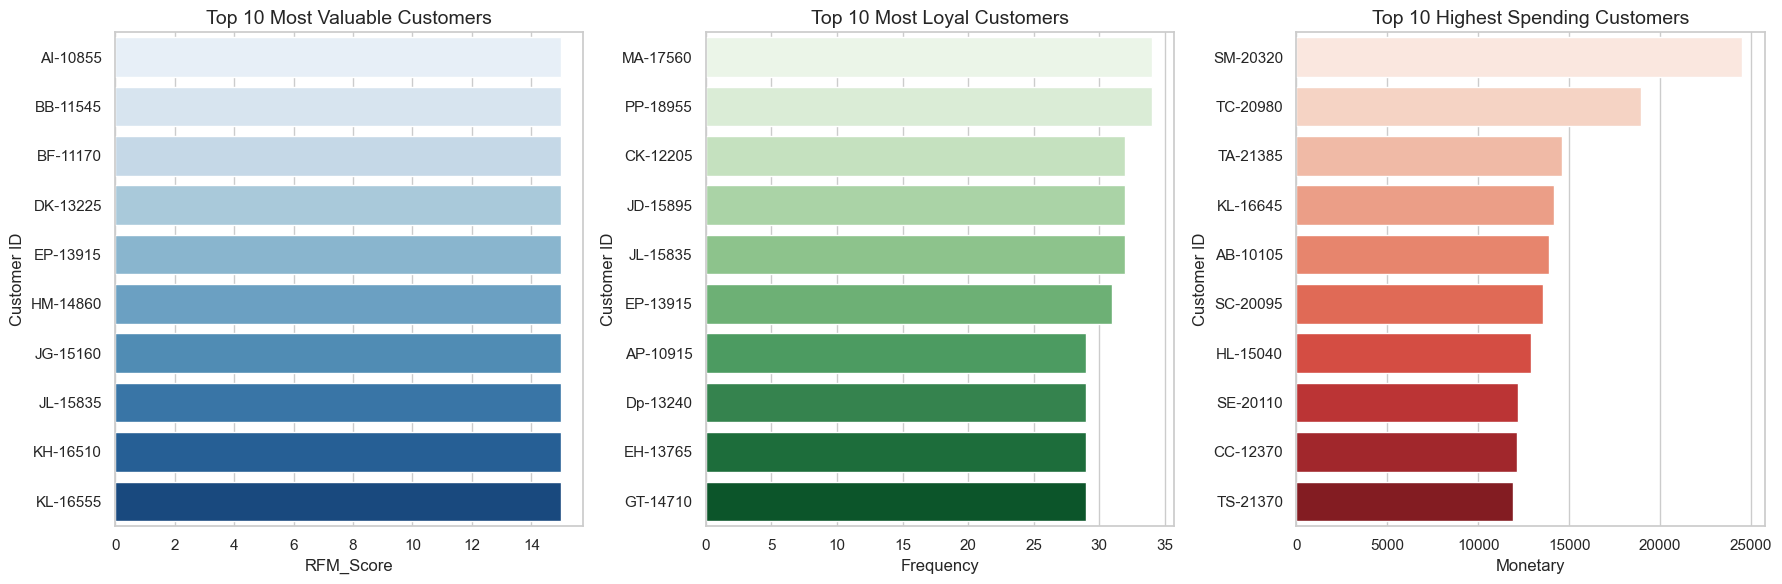

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

### 1️⃣ Bar Charts: Top 10 Customers in Each Category ###
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define top 10 customers
top_valuable = rfm.nlargest(10, "RFM_Score")  
top_loyal = rfm.nlargest(10, "Frequency")  
top_spenders = rfm.nlargest(10, "Monetary")  

# Function to create bar charts
def plot_bar_chart(ax, df, column, title, color_palette):
    sns.barplot(y=df.index, x=df[column], ax=ax, palette=sns.color_palette(color_palette, 10))
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(column, fontsize=12)
    ax.set_ylabel("Customer ID", fontsize=12)

# Fix: Ensure 'color_palette' argument is passed correctly
plot_bar_chart(axes[0], top_valuable, "RFM_Score", "Top 10 Most Valuable Customers", "Blues")
plot_bar_chart(axes[1], top_loyal, "Frequency", "Top 10 Most Loyal Customers", "Greens")
plot_bar_chart(axes[2], top_spenders, "Monetary", "Top 10 Highest Spending Customers", "Reds")

plt.tight_layout()
plt.show()


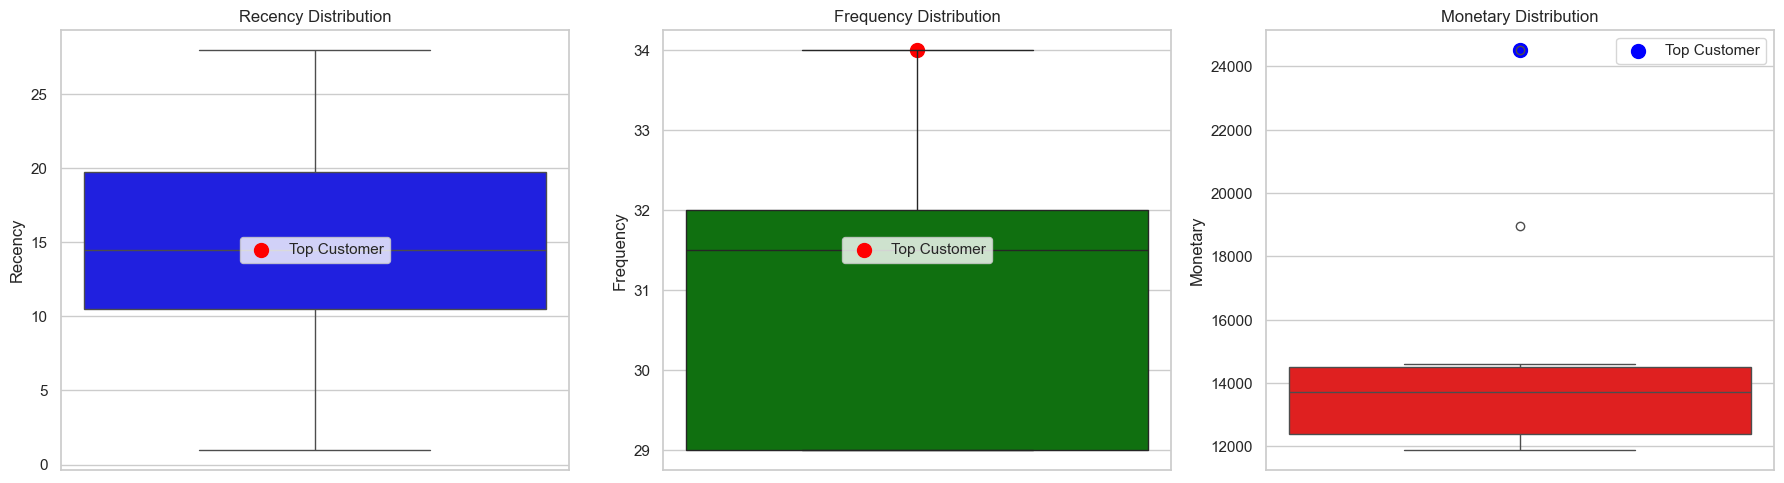


🔝 **Topmost Customers in Each Category:**
🏆 Most Valuable Customer: AI-10855 - RFM Score: 15.0
🔁 Most Loyal Customer: MA-17560 - Frequency: 34.0
💰 Highest Spending Customer: SM-20320 - Monetary: 24516.6


In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the Top 10 Customers in Each Category
top_valuable = rfm.nlargest(10, "RFM_Score")
top_loyal = rfm.nlargest(10, "Frequency")
top_spenders = rfm.nlargest(10, "Monetary")

# Get the Topmost Customer in Each Category
top_valuable_customer = top_valuable.iloc[0]  # Most Valuable Customer
top_loyal_customer = top_loyal.iloc[0]  # Most Loyal Customer
top_spender_customer = top_spenders.iloc[0]  # Highest Spending Customer

### 2️⃣ **Boxplots to Compare the Topmost Customer with Other Top 10** ###
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Boxplot for Recency
sns.boxplot(y=top_valuable["Recency"], ax=axes[0], color="blue")
axes[0].scatter(0, top_valuable_customer["Recency"], color="red", s=100, label="Top Customer")
axes[0].set_title("Recency Distribution")

# Boxplot for Frequency
sns.boxplot(y=top_loyal["Frequency"], ax=axes[1], color="green")
axes[1].scatter(0, top_loyal_customer["Frequency"], color="red", s=100, label="Top Customer")
axes[1].set_title("Frequency Distribution")

# Boxplot for Monetary
sns.boxplot(y=top_spenders["Monetary"], ax=axes[2], color="red")
axes[2].scatter(0, top_spender_customer["Monetary"], color="blue", s=100, label="Top Customer")
axes[2].set_title("Monetary Distribution")

# Add legends
for ax in axes:
    ax.legend()

plt.tight_layout()
plt.show()

# Print topmost customers
print("\n🔝 **Topmost Customers in Each Category:**")
print(f"🏆 Most Valuable Customer: {top_valuable_customer.name} - RFM Score: {top_valuable_customer['RFM_Score']}")
print(f"🔁 Most Loyal Customer: {top_loyal_customer.name} - Frequency: {top_loyal_customer['Frequency']}")
print(f"💰 Highest Spending Customer: {top_spender_customer.name} - Monetary: {top_spender_customer['Monetary']}")
